# Activity 12: Cross-validation

---
In this activity, we'll train and evaluate a model on the now-familiar [Wisconsin Breast Cancer Diagnosis Dataset][1], but this time we'll use cross-validation.

Goals are as follows:

- Learn how to partition the data into folds
- Implement the cross validation procedure
- Save and present results fod all folds

[1]: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

As in assignment 1, we'll use `sklearn` to load the dataset. For details, please refer to earlier exercises.

**Important**: if you encounter an error with `load_breast_cancer`, try upgrading `sklearn` by adding a code block with the following:
> `!pip install --upgrade scikit-learn`

In [2]:
from sklearn.datasets import load_breast_cancer

df, y_true = load_breast_cancer(return_X_y=True, as_frame=True)
y_true = 1 - y_true # let's set benign to 0 and malignant to 1, in keeping with usual conventions

def flip_some_labels(labels, flip_rate=.1, random_seed=0):
    return (labels + (np.random.RandomState(random_seed).rand(len(labels)) < flip_rate)) % 2

y = flip_some_labels(y_true)

We're now ready to begin exploring cross-validation.

## Part 1: Divide the data into equally sized folds (at random)

The first step in cross-validation is to randomly assign our samples into equal-sized groups, or *folds*. If these folds are too big, we'll have less data to use for training, but if they're too small, it'll take us a long time to finish the cross-validation procedure, which requires us to train one model per fold.

There are lots of different ways you might randomly assign samples to folds. Please use the approach that feels easiest or most comfortable. Some options:

- In the block below, I've provided code that generates a fold index (`fold_idx`) that assigns samples to folds at random. It is based on `np.random.permutation`, which randomly shuffles a list of items. I find it to be a concise and simple approach. The block below also provides an example that shows how you can select fold 0 based on `fold_idx`.
- A commonly used alternative is [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) from `sklearn.model_selection`. This is a nice approach partly because `sklearn` is widely used, so you'll always be able to rely on it being available.
- Conceptually, the simplest approach is probably to shuffle the data, then divide it into folds sequentially. However, this is a bit more difficult to implement than you might expect, because (a) you have to apply the same shuffle to the data and labels, and (b) you still have to calculate the start and end position of each fold.

Start by choosing how many folds you'll use. In the example below, I've used 5, which is common. Whatever approach you choose, please take a moment to explore your method and verify it is functioning as expected.

In [3]:
### DIVIDE THE DATA INTO FOLDS ###

N_folds = 5

def create_fold_index(N_samples, N_folds, random_state=0):
    return np.random.RandomState(random_state).permutation(N_samples) * N_folds // N_samples

fold_idx = create_fold_index(len(df), N_folds)

### WE CAN NOW ACCESS FOLD 0 AS FOLLOWS: ###

x_fold_0 = df[fold_idx == 0]
y_fold_0 = y[fold_idx == 0]

## Part 2: Train and evaluate a model of your choice across all folds

We now train and evaluate our model N times: once **for each of our N folds**. Specifically, we evaluate on each fold by training our model on all *other* folds. For a given fold, the process is familiar: we define our training and test sets, standardize our data (if needed), train on the training set, and evaluate on the test set. Unlike before, though, we'll need to save our performance measures across all folds, then aggregate them (e.g. mean, standard deviation) after the process is complete.

In the block below, you should build on the outline provided to implement the cross-validation procedure. You can use any model you like. However, we are *not* yet ready to tune hyperparameters, so if your model contains any, you should simply set them to reasonable (e.g. default) values. Make sure to calculate the prediction accuracy, AUC, and average precision for each fold, then append those values to `fold_acc`, `fold_auc`, and `fold_avg`, respectively.

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

fold_acc = []
fold_auc = []
fold_avp = []

for i in range(N_folds):
    
    x_train = df[fold_idx != i]
    x_test = df[fold_idx == i]
    
    y_train = y[fold_idx != i]
    y_test = y[fold_idx == i]
    
    ### STANDARDIZE THE DATA (Optional; important for neural networks, less so for logistic regression) ###
    
    x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)
    x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)    
    
    ### TRAIN THE MODEL ON THE TRAINING SET ###
    
    lr_model = LogisticRegression().fit(x_train, y_train)
    
    ### EVALUATE PERFORMANCE ON THE TEST SET ###
    
    y_pred_proba = lr_model.predict_proba(x_test)
    
    ### SAVE THE PERFORMANCE FIGURES ###
    
    fold_acc.append(np.mean(np.argmax(y_pred_proba, axis=1) == y_test))
    fold_auc.append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    fold_avp.append(average_precision_score(y_test, y_pred_proba[:, 1]))

## Part 3: Characterize performance across all folds

In the block below, characterize accuracy, AUC, and average precision by calculating the mean and standard deviation of these values across all folds.

In [5]:
### Calculate the mean +- SD of accuracy, AUC, and average precision and print results ###

print('The accuracy is %.1f%% \u00B1 %.1f%%' % (100 * np.mean(fold_acc), 100 * np.std(fold_acc)))
print('The AUC is %.3f \u00B1 %.3f' % (np.mean(fold_auc), np.std(fold_auc)))
print('The average precision is %.3f \u00B1 %.3f' % (np.mean(fold_avp), np.std(fold_avp)))

The accuracy is 85.1% ± 3.9%
The AUC is 0.870 ± 0.041
The average precision is 0.851 ± 0.045


## (challenge) Part 4: Plot the ROC and PR curves for each fold

It can be instructive to plot the ROC and PR curves for all folds rather than simply summarizing the AUC and average precision. You can do this by adding any of the following to the cross-validation procedure:
- plot these curves as you go, i.e. keep plotting them for the current fold
- saving the values that define these curves for each fold, then plot them all at the end
- save your model's predictions for each fold, then generate the ROC and PR curves afterward based on these values

The accuracy is 85.1% ± 3.9%
The AUC is 0.870 ± 0.041
The average precision is 0.851 ± 0.045


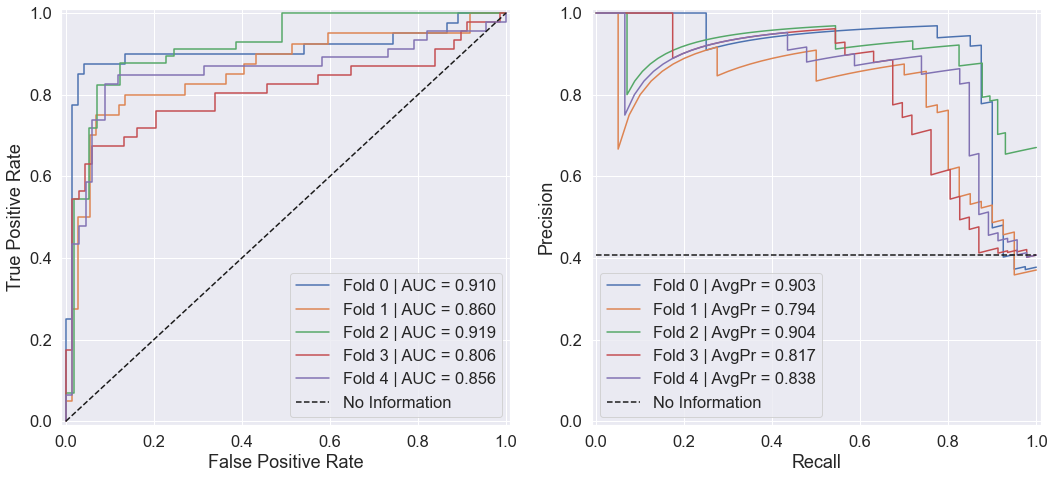

In [6]:
from sklearn.metrics import roc_curve, precision_recall_curve
import seaborn as sns
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

for i in range(N_folds):
    
    x_train = df[fold_idx != i]
    x_test = df[fold_idx == i]
    
    y_train = y[fold_idx != i]
    y_test = y[fold_idx == i]
    
    ### STANDARDIZE THE DATA (Optional; important for neural networks, less so for logistic regression) ###
    
    x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)
    x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)    
    
    ### TRAIN THE MODEL ON THE TRAINING SET ###
    
    lr_model = LogisticRegression().fit(x_train, y_train)
    
    ### EVALUATE PERFORMANCE ON THE TEST SET ###
    
    y_pred_proba = lr_model.predict_proba(x_test)
    
    ### CALCULATE PERFORMANCE FIGURES ###
    
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    avp = average_precision_score(y_test, y_pred_proba[:, 1])
    
    fold_acc.append(np.mean(np.argmax(y_pred_proba, axis=1) == y_test))
    fold_auc.append(auc)
    fold_avp.append(avp)
    
    ### PLOT ROC AND PR CURVES FOR CURRENT FOLD ###
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    pr, re, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    
    ax[0].plot(fpr, tpr, label='Fold %i | AUC = %.3f' % (i, auc))
    ax[1].plot(re, pr, label='Fold %i | AvgPr = %.3f' % (i, avp))
    
ax[0].set_xlim([-.01, 1.01])
ax[0].set_ylim([-.01, 1.01])
ax[0].plot([0, 1], [0, 1], 'k--', label='No Information')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

ax[1].set_xlim([-.01, 1.01])
ax[1].set_ylim([-.01, 1.01])
ax[1].plot([0, 1], [np.mean(y_test), np.mean(y_test)], 'k--', label='No Information')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()

print('The accuracy is %.1f%% \u00B1 %.1f%%' % (100 * np.mean(fold_acc), 100 * np.std(fold_acc)))
print('The AUC is %.3f \u00B1 %.3f' % (np.mean(fold_auc), np.std(fold_auc)))
print('The average precision is %.3f \u00B1 %.3f' % (np.mean(fold_avp), np.std(fold_avp)))

plt.tight_layout()
plt.show()

## (challenge) Part 5: Tune hyperparameters

Many of our models have hyperparameters we'd like to tune, which requires a validation set. As a final, optional challenge, choose a model that has hyperparameters, then tune them during cross-validation by:
1. further dividing your training set (for the current fold) into a training set and a validation set
2. training models with a variety of hyperparameter settings
3. determine which hyperparameters perform best on the validation set
4. apply a model with hyperparameters identified in (3) to the current test set (i.e. fold)

To extend this challenge further, implement nested cross-validation, in which you loop over all possible validation sets within each fold.

The accuracy is 85.2% ± 4.6%
The AUC is 0.867 ± 0.037
The average precision is 0.853 ± 0.047


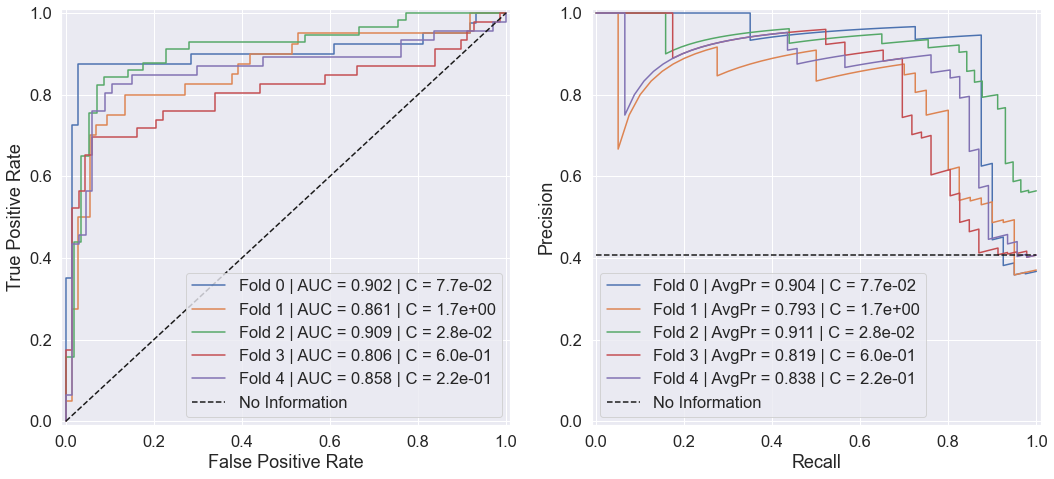

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

C_values = np.logspace(-2, 2, 10)

fold_acc = []
fold_auc = []
fold_avp = []

for i in range(N_folds):
    
    # search for best C value
    
    avg_auc_by_C = []
    
    for k, C in enumerate(C_values):
        
        # nested cross-validation: rotate validation set
        
        val_auc = []
        
        for j in range(N_folds):
            
            print('Running fold %i.%i.%i' % (i, k, j), end='\r')
            
            if i == j:
                continue
    
            x_train = df[(fold_idx != i) & (fold_idx != j)]
            x_val = df[fold_idx == j]
            x_test = df[fold_idx == i]

            y_train = y[(fold_idx != i) & (fold_idx != j)]
            y_val = y[fold_idx == j]
            y_test = y[fold_idx == i]

            ### STANDARDIZE THE DATA (Optional; important for neural networks, less so for logistic regression) ###

            x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)
            x_val = (x_val - x_train.mean(axis=0)) / x_train.std(axis=0)
            x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)    

            ### TRAIN THE MODEL ON THE TRAINING SET ###

            lr_model = LogisticRegression(C=C, max_iter=5000).fit(x_train, y_train)
            val_auc.append(roc_auc_score(y_val, lr_model.predict_proba(x_val)[:, 1]))
            
        avg_auc_by_C.append(np.mean(val_auc))
        
    # choose C value with best performance (on average) on the validation sets
        
    best_C = C_values[np.argmax(avg_auc_by_C)]
    
    # train the final model for this fold
    
    x_train = df[fold_idx != i]
    x_test = df[fold_idx == i]
    
    y_train = y[fold_idx != i]
    y_test = y[fold_idx == i]
    
    x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)
    x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
    
    lr_model = LogisticRegression(C=best_C, max_iter=5000).fit(x_train, y_train)
    
    ### EVALUATE PERFORMANCE ON THE TEST SET ###
    
    y_pred_proba = lr_model.predict_proba(x_test)
    
    ### CALCULATE PERFORMANCE FIGURES ###
    
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    avp = average_precision_score(y_test, y_pred_proba[:, 1])
    
    fold_acc.append(np.mean(np.argmax(y_pred_proba, axis=1) == y_test))
    fold_auc.append(auc)
    fold_avp.append(avp)
    
    ### PLOT ROC AND PR CURVES FOR CURRENT FOLD ###
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    pr, re, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    
    ax[0].plot(fpr, tpr, label='Fold %i | AUC = %.3f | C = %.1e' % (i, auc, best_C))
    ax[1].plot(re, pr, label='Fold %i | AvgPr = %.3f | C = %.1e' % (i, avp, best_C))
    
ax[0].set_xlim([-.01, 1.01])
ax[0].set_ylim([-.01, 1.01])
ax[0].plot([0, 1], [0, 1], 'k--', label='No Information')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

ax[1].set_xlim([-.01, 1.01])
ax[1].set_ylim([-.01, 1.01])
ax[1].plot([0, 1], [np.mean(y_test), np.mean(y_test)], 'k--', label='No Information')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()

print('The accuracy is %.1f%% \u00B1 %.1f%%' % (100 * np.mean(fold_acc), 100 * np.std(fold_acc)))
print('The AUC is %.3f \u00B1 %.3f' % (np.mean(fold_auc), np.std(fold_auc)))
print('The average precision is %.3f \u00B1 %.3f' % (np.mean(fold_avp), np.std(fold_avp)))

plt.tight_layout()
plt.show()